In [ ]:
# import libraries
import pandas as pd
import numpy as np
import sys
import sklearn
import io
import random

In [ ]:
## add the columns' name and read the KDDTrain+ and KDDTest+ datasets
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

#training set
df = pd.read_csv("/content/NSL_KDD_Train.csv",header=None, names = col_names)
#testing set
df_test = pd.read_csv("/content/NSL_KDD_Test.csv", header=None, names = col_names)

print('Dimensions of the Training set:',df.shape)
print('Dimensions of the Test set:',df_test.shape)

Dimensions of the Training set: (125973, 42)
Dimensions of the Test set: (22544, 42)


In [ ]:
print('Label distribution in the Training set:')
print("****************************************")
print(df['label'].value_counts())

Label distribution in the Training set:
****************************************
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: label, dtype: int64


In [ ]:
print('Label distribution in the Test set:')
print("**************************************")
print(df_test['label'].value_counts())

Label distribution in the Test set:
**************************************
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178
portsweep           157
ipsweep             141
httptunnel          133
nmap                 73
pod                  41
buffer_overflow      20
multihop             18
named                17
ps                   15
sendmail             14
rootkit              13
xterm                13
teardrop             12
xlock                 9
land                  7
xsnoop                4
ftp_write             3
worm                  2
loadmodule            2
perl                  2
sqlattack             2
udpstorm              2
phf                   2
imap                  1
Name: label, 

# **Step 1: Data preprocessing:**

One-Hot-Encoding is used to convert all categorical properties to binary properties. One-Hot-Endcoding requirement, the input to this transformer must be an integer matrix expressing values taken with categorical (discrete) properties. The output will be a sparse matrix in which each column corresponds to a possible value. It is assumed that the input properties have values in the range [0, n_values]. Therefore, to convert each category to a number, properties must first be converted with LabelEncoder.

In [ ]:
# columns are categorical, not yet binary: protocol_type (column 2), service (column 3), flag (column 4).

print('Training set:')
for col_name in df.columns:
    if df[col_name].dtypes == 'object' :
        unique_cat = len(df[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

print()
print('Distribution of categories in service:')
print(df['service'].value_counts().sort_values(ascending=False).head())

Training set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 70 categories
Feature 'flag' has 11 categories
Feature 'label' has 23 categories

Distribution of categories in service:
http        40338
private     21853
domain_u     9043
smtp         7313
ftp_data     6860
Name: service, dtype: int64


In [ ]:
# Test set
print('Test set:')
for col_name in df_test.columns:
    if df_test[col_name].dtypes == 'object' :
        unique_cat = len(df_test[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

Test set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 64 categories
Feature 'flag' has 11 categories
Feature 'label' has 38 categories


**LabelEncoder**

**Insert categorical features into a 2D numpy array**

In [ ]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
categorical_columns=['protocol_type', 'service', 'flag']

df_categorical_values = df[categorical_columns]
testdf_categorical_values = df_test[categorical_columns]

df_categorical_values.head()

,protocol_type,service,flag
0,tcp,ftp_data,SF
1,udp,other,SF
2,tcp,private,S0
3,tcp,http,SF
4,tcp,http,SF


In [ ]:
# protocol type
unique_protocol=sorted(df.protocol_type.unique())
string1 = 'Protocol_type_'
unique_protocol2=[string1 + x for x in unique_protocol]
print(unique_protocol2)

# service
unique_service=sorted(df.service.unique())
string2 = 'service_'
unique_service2=[string2 + x for x in unique_service]
print(unique_service2)


# flag
unique_flag=sorted(df.flag.unique())
string3 = 'flag_'
unique_flag2=[string3 + x for x in unique_flag]
print(unique_flag2)


# put together
dumcols=unique_protocol2 + unique_service2 + unique_flag2


#do it for test set
unique_service_test=sorted(df_test.service.unique())
unique_service2_test=[string2 + x for x in unique_service_test]
testdumcols=unique_protocol2 + unique_service2_test + unique_flag2


['Protocol_type_icmp', 'Protocol_type_tcp', 'Protocol_type_udp']
['service_IRC', 'service_X11', 'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec', 'service_finger', 'service_ftp', 'service_ftp_data', 'service_gopher', 'service_harvest', 'service_hostnames', 'service_http', 'service_http_2784', 'service_http_443', 'service_http_8001', 'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell', 'service_ldap', 'service_link', 'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm', 'service_netbios_ns', 'service_netbios_ssn', 'service_netstat', 'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_other', 'service_pm_dump', 'service_pop_2', 'service_pop_3', 'service_printer', 'service_private', 'service_red_i', 'service_remote_job', 'ser

**Transform categorical features into numbers using LabelEncoder()**

In [ ]:
# train set
df_categorical_values_enc=df_categorical_values.apply(LabelEncoder().fit_transform)
print(df_categorical_values.head())
print('--------------------')
print(df_categorical_values_enc.head())
# test set
testdf_categorical_values_enc=testdf_categorical_values.apply(LabelEncoder().fit_transform)

  protocol_type   service flag
0           tcp  ftp_data   SF
1           udp     other   SF
2           tcp   private   S0
3           tcp      http   SF
4           tcp      http   SF
--------------------
   protocol_type  service  flag
0              1       20     9
1              2       44     9
2              1       49     5
3              1       24     9
4              1       24     9


**One-Hot-Encoding**

In [ ]:
# train set
enc = OneHotEncoder(categories='auto')
df_categorical_values_encenc = enc.fit_transform(df_categorical_values_enc)
df_cat_data = pd.DataFrame(df_categorical_values_encenc.toarray(),columns=dumcols)
# test set
testdf_categorical_values_encenc = enc.fit_transform(testdf_categorical_values_enc)
testdf_cat_data = pd.DataFrame(testdf_categorical_values_encenc.toarray(),columns=testdumcols)

Missing columns in test set are added




In [ ]:
trainservice=df['service'].tolist()
testservice= df_test['service'].tolist()
difference=list(set(trainservice) - set(testservice))
string = 'service_'
difference=[string + x for x in difference]

for col in difference:
    testdf_cat_data[col] = 0

print(df_cat_data.shape)
print(testdf_cat_data.shape)

(125973, 84)
(22544, 84)


New numeric columns are added to main dataframe

In [ ]:
newdf=df.join(df_cat_data)
newdf.drop('flag', axis=1, inplace=True)
newdf.drop('protocol_type', axis=1, inplace=True)
newdf.drop('service', axis=1, inplace=True)

# test data
newdf_test=df_test.join(testdf_cat_data)
newdf_test.drop('flag', axis=1, inplace=True)
newdf_test.drop('protocol_type', axis=1, inplace=True)
newdf_test.drop('service', axis=1, inplace=True)

print(newdf.shape)
print(newdf_test.shape)

(125973, 123)
(22544, 123)


In [ ]:
# Convert the "label" catagorical values into numerical values

labeldf=newdf['label']
labeldf_test=newdf_test['label']

# change the label column
newlabeldf=labeldf.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})
newlabeldf_test=labeldf_test.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})



In [ ]:
# put the new label column back
newdf['label'] = newlabeldf
newdf_test['label'] = newlabeldf_test

In [ ]:
#Convert "label" into normal=0 and attack=1 for KDDTrain+
newdf['class']=newdf['label'].apply(lambda x: 1 if x>=1 else 0)
newdf.drop(['label'], axis=1)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,class
0,0,491,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,0,146,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
3,0,232,8153,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,0,199,420,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
125969,8,105,145,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
125970,0,2231,384,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
125971,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
#Convert "label" into normal=0 and attack=1 for KDDTest+
newdf_test['class']=newdf_test['label'].apply(lambda x: 1 if x>=1 else 0)
newdf_test.drop(['label'],1)

<ipython-input-18-d90236f2e6fe>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  newdf_test.drop(['label'],1)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_S3,flag_SF,flag_SH,service_http_2784,service_http_8001,service_urh_i,service_aol,service_red_i,service_harvest,class
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,1
2,2,12983,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0,0,0,0,0,0,0
3,0,20,0,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0,0,0,0,0,0,1
4,1,0,15,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,794,333,0,0,0,0,0,1,0,...,0.0,1.0,0.0,0,0,0,0,0,0,0
22540,0,317,938,0,0,0,0,0,1,0,...,0.0,1.0,0.0,0,0,0,0,0,0,0
22541,0,54540,8314,0,0,0,2,0,1,1,...,0.0,1.0,0.0,0,0,0,0,0,0,1
22542,0,42,42,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0,0,0,0,0,0,0


In [ ]:
newdf.groupby('class').count()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
class,,,,,,,,,,,,,,,,,,,,,
0,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343,...,67343,67343,67343,67343,67343,67343,67343,67343,67343,67343
1,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630,...,58630,58630,58630,58630,58630,58630,58630,58630,58630,58630


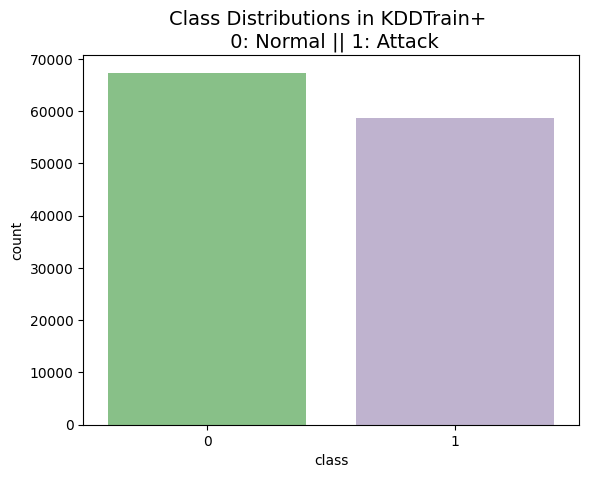

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x="class", data=newdf, palette="Accent")
plt.title('Class Distributions in KDDTrain+ \n 0: Normal || 1: Attack', fontsize=14)
plt.show()

In [ ]:
newdf_test.groupby('class').count()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_S2,flag_S3,flag_SF,flag_SH,service_http_2784,service_http_8001,service_urh_i,service_aol,service_red_i,service_harvest
class,,,,,,,,,,,,,,,,,,,,,
0,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711,...,9711,9711,9711,9711,9711,9711,9711,9711,9711,9711
1,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833,...,12833,12833,12833,12833,12833,12833,12833,12833,12833,12833


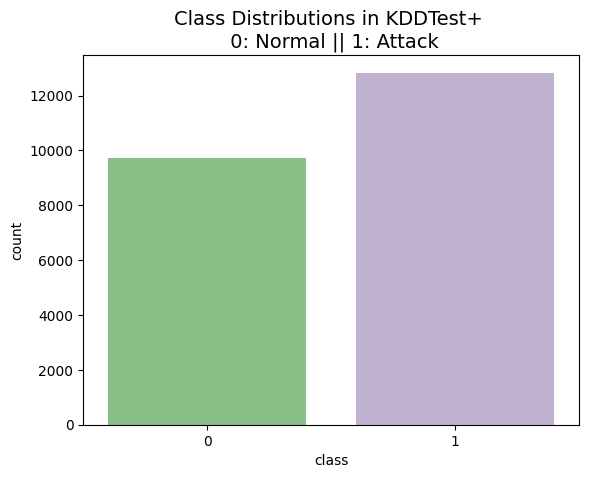

In [ ]:
sns.countplot(x="class", data=newdf_test, palette="Accent")
plt.title('Class Distributions in KDDTest+ \n 0: Normal || 1: Attack', fontsize=14)
plt.show()

Epoch 1/5
3937/3937 [==============================] - 189s 48ms/step - loss: 0.2806 - accuracy: 0.9051 - val_loss: 0.8127 - val_accuracy: 0.7304
Epoch 2/5
3937/3937 [==============================] - 167s 43ms/step - loss: 0.1040 - accuracy: 0.9620 - val_loss: 0.7458 - val_accuracy: 0.7732
Epoch 3/5
3937/3937 [==============================] - 168s 43ms/step - loss: 0.0619 - accuracy: 0.9773 - val_loss: 0.9577 - val_accuracy: 0.7860
Epoch 4/5
3937/3937 [==============================] - 166s 42ms/step - loss: 0.0457 - accuracy: 0.9831 - val_loss: 1.1611 - val_accuracy: 0.7838
Epoch 5/5
705/705 [==============================] - 11s 15ms/step - loss: 1.2133 - accuracy: 0.7864
Test Loss: 1.2133492231369019
Test Accuracy: 0.7864176630973816


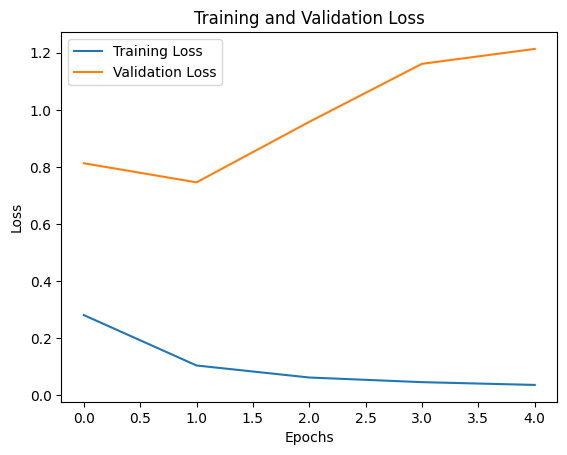

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


# Convert categorical columns to numerical using label encoding
categorical_columns = ['protocol_type', 'service', 'flag']
for column in categorical_columns:
    le = LabelEncoder()
    le.fit(df_train[column])  # Fit the encoder on training + test data
    df_train[column] = le.transform(df_train[column])
    df_test[column] = le.transform(df_test[column])

# Separate the features and target variable
x_train = df_train.drop('label', axis=1)
y_train = df_train['label']
x_test = df_test.drop('label', axis=1)
y_test = df_test['label']

# Scale the numerical features using StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Apply PCA for feature scaling
pca = PCA(n_components=30)  # Choose the number of principal components
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)

# Convert the target variable into binary classification (0: non-attack, 1: attack)
y_train_binary = (y_train != 'normal').astype(int)
y_test_binary = (y_test != 'normal').astype(int)

# Reshape the input data for LSTM
x_train_reshaped = x_train_pca.reshape((x_train_pca.shape[0], x_train_pca.shape[1], 1))
x_test_reshaped = x_test_pca.reshape((x_test_pca.shape[0], x_test_pca.shape[1], 1))

# Create and compile the LSTM model
model = keras.Sequential()
model.add(LSTM(128, input_shape=(x_train_reshaped.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.002, epsilon=1e-08)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train_reshaped, y_train_binary, epochs=5, batch_size=32, validation_data=(x_test_reshaped, y_test_binary))

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test_reshaped, y_test_binary)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
